## 데이터를 어떻게 불러오는지 파악하고, 시각화 해보기

In [1]:
# package import
import os

import numpy as np
from PIL import Image
import random

import xml.etree.ElementTree as ET

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')

In [3]:
def read_image(path, dtype=np.float32, color=True):
    """Read an image from a file.
    This function reads an image from given file. The image is CHW format and
    the range of its value is :math:`[0, 255]`. If :obj:`color = True`, the
    order of the channels is RGB.
    Args:
        path (str): A path of image file.
        dtype: The type of array. The default value is :obj:`~numpy.float32`.
        color (bool): This option determines the number of channels.
            If :obj:`True`, the number of channels is three. In this case,
            the order of the channels is RGB. This is the default behaviour.
            If :obj:`False`, this function returns a grayscale image.
    Returns:
        ~numpy.ndarray: An image.
    """

    f = Image.open(path)
    try:
        if color:
            img = f.convert('RGB')
        else:
            img = f.convert('P')
        img = np.asarray(img, dtype=dtype)
    finally:
        if hasattr(f, 'close'):
            f.close()

    if img.ndim == 2:
        # reshape (H, W) -> (1, H, W)
        return img[np.newaxis]
    else:
        # transpose (H, W, C) -> (C, H, W)
        return img.transpose((2, 0, 1))

In [4]:
cwd = os.getcwd()

In [5]:
path = os.path.join(cwd, 'VOCdevkit/VOC2007/Annotations')
id_list = os.listdir(path)
print(id_list[:5])

['000005.xml', '000007.xml', '000009.xml', '000012.xml', '000016.xml']


## id 정보 및 이미지 불러오기
- bbox 좌표, label 등을 xml 파일에서 불러오기
- 이미지 불러오기(read_image 함수 사용)

In [6]:
id_ = id_list[0][:6] #간단하게 첫번째 즉 index=0 이미지 불러오기
print('id: ',id_)
anno = ET.parse(os.path.join(path, id_ + '.xml'))
bbox = list()
label = list()
difficult = list()
for obj in anno.findall('object'):
    difficult.append(int(obj.find('difficult').text))
    bndbox_anno = obj.find('bndbox')

    bbox.append([
        int(bndbox_anno.find(tag).text) - 1
        for tag in ('ymin', 'xmin','ymax', 'xmax')
    ])
    name = obj.find('name').text.lower().strip()
    label.append(VOC_BBOX_LABEL_NAMES.index(name))
bbox = np.stack(bbox).astype(np.float32)
label = np.stack(label).astype(np.int32)
difficult = np.array(difficult, dtype = np.bool).astype(np.uint8)

#load a image
img_file = os.path.join(cwd, 'VOCdevkit/VOC2007/JPEGImages', id_ +'.jpg')
img = read_image(img_file, color = True)

id:  000005


## 시각화 해보기

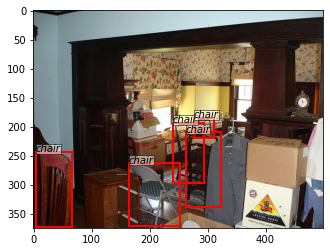

In [7]:
label_names = list(VOC_BBOX_LABEL_NAMES) + ['bg']
fig, ax = plt.subplots()
img = img.transpose(1,2,0)
for i, bb in enumerate(bbox):
    xy = (bb[1], bb[0])
    height = bb[2] - bb[0]
    width = bb[3] - bb[1]
    ax.add_patch(plt.Rectangle(
        xy, width, height, fill = False, edgecolor = 'red', linewidth = 2))
    caption = list()
    lb = label[i]
    caption.append(label_names[lb])
    ax.text(bb[1], bb[0], ': '.join(caption),
           style = 'italic',
           bbox = {'facecolor':'white', 'alpha':0.5, 'pad':0})
ax = ax.imshow(img.astype(np.uint8))
plt.show()